# CNN model training

## LAQN air quality prediction

## what this notebook does?

this notebook trains a convolutional neural network (CNN) to predict nitrogen dioxide (NO2) levels using the same LAQN data that was used for random forest. the goal is to compare CNN performance against the random forest baseline (test R² = 0.814).

## 1. setup and imports

First, as usual import everything. 
tensorflow/keras is the deep learning library. 
numpy handles arrays. 
matplotlib and seaborn make plots.

In [43]:
# std libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# import for kerasTuning
import keras
import keras_tuner

# scikit-learn for metrics r^2, MSE, MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# tensorflow and keras for neural network
import tensorflow as tf
from tensorflow import keras
import platform

# adding tensorflow keras models, layers optimizer adam  for cnn model section 4

from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

#callbacks early stopping modules section 5

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# residual distribution section 8
from sklearn.metrics import PredictionErrorDisplay


        operating system: Darwin
        processor: arm
        tensorflow version: 2.16.2
        built with CUDA: False

        available devices:
        - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

In [7]:
# set paths update this to match your folder structure using cwd
base_dir = Path.cwd().parent.parent / 'data' / 'laqn'
data_dir = base_dir / 'ml_prep' # where ml_prep saved the arrays
output_dir = base_dir / 'cnn_model' # where we save CNN outputs 
output_dir.mkdir(parents=True, exist_ok=True)

print(f'loading data from: {data_dir}')
print(f'saving outputs to: {output_dir}')

loading data from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/ml_prep
saving outputs to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model



### GPU availability

- TensorFlow code, and tf.keras models will transparently run on a single GPU with no code changes required.
> Note: Use tf.config.list_physical_devices('GPU') to confirm that TensorFlow is using the GPU.
- The simplest way to run on multiple GPUs, on one or many machines, is using Distribution Strategies.

Source: *Use a GPU :  Tensorflow Core* (no date) *TensorFlow*



In [2]:
# checks gpu availability taken from documentation.

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'GPU available: {len(gpus)} device(s)')
    for gpu in gpus:
        print(f'  - {gpu.name}')
else:
    print('no GPU found, using CPU (training will be slower but still works)')

no GPU found, using CPU (training will be slower but still works)


## 2. load prepared data

the data was prepared in ml_prep notebook. it created sequences where each sample has 12 hours of history to predict the next hour. this is the same data random forest used, just in 3D shape instead of flattened.

### why 3D data for CNN?

random forest needs flat 2D data: (samples, features). CNN needs 3D data: (samples, timesteps, features). the 3D shape lets CNN learn patterns across time, not just treat each timestep as an independent feature.

think of it like this:
- 2D (random forest): each row is a list of 468 numbers with no structure
- 3D (CNN): each sample is a 12×39 grid where rows are hours and columns are features

In [14]:
# load the 3d sequences for cnn
X_train = np.load(data_dir / 'X_train.npy')
X_val = np.load(data_dir / 'X_val.npy')
X_test = np.load(data_dir / 'X_test.npy')

y_train = np.load(data_dir / 'y_train.npy')
y_val = np.load(data_dir / 'y_val.npy')
y_test = np.load(data_dir / 'y_test.npy')

#load feature_names and scaler
feature_names = joblib.load(data_dir / 'feature_names.joblib')
scaler = joblib.load(data_dir / 'scaler.joblib')

print('data loaded successfully')
print(f'\nshapes:')
print(f'X_train:{X_train.shape}')
print(f'X_val:{X_val.shape}')
print(f'X_test:{X_test.shape}')
print(f'y_train:{y_train.shape}')
print(f'y_val:{y_val.shape}')
print(f'y_test:{y_test.shape}')

data loaded successfully

shapes:
X_train:(9946, 12, 39)
X_val:(2131, 12, 39)
X_test:(2132, 12, 39)
y_train:(9946, 39)
y_val:(2131, 39)
y_test:(2132, 39)


    data loaded successfully

    shapes:
    X_train:(9946, 12, 39)
    X_val:(2131, 12, 39)
    X_test:(2132, 12, 39)
    y_train:(9946, 39)
    y_val:(2131, 39)
    y_test:(2132, 39)

### understanding the shapes

X_train shape is (9946, 12, 39). this means:

| dimension | value | what it represents |
|-----------|-------|-------------------|
| samples | 9,946 | individual training examples |
| timesteps | 12 | hours of history per sample |
| features | 39 | 24 NO2 + 8 PM10 + 3 O3 + 4 temporal |

y_train shape is (9946, 39). the model predicts all 39 features for the next hour.

for fair comparison with random forest, I focus on EN5_NO2 (first column) as the single target. this is the same station used in the RF training report. EN5 had the highest data coverage (99.6%) which makes it the most reliable target for evaluation.

the 3D shape is the key difference from random forest:
- random forest got flattened 2D: (9946, 468) where 468 = 12 × 39
- CNN keeps the 3D structure: (9946, 12, 39)

why does this matter? CNN can learn that hour 1 connects to hour 2 connects to hour 3. random forest just sees 468 separate numbers with no time relationship. this is why CNN might capture temporal patterns better.

In [9]:
# select single target as RF EN5_NO2
target_idx = 0
target_name = feature_names[target_idx]

y_train_single = y_train[:, target_idx]
y_val_single = y_val[:, target_idx]
y_test_single = y_test[:, target_idx]

print(f'target feature: {target_name}')
print(f'y_train_single shape: {y_train_single.shape}')
print(f'y_val_single shape: {y_val_single.shape}')
print(f'y_test_single shape: {y_test_single.shape}')

target feature: EN5_NO2
y_train_single shape: (9946,)
y_val_single shape: (2131,)
y_test_single shape: (2132,)


    target feature: EN5_NO2
    y_train_single shape: (9946,)
    y_val_single shape: (2131,)
    y_test_single shape: (2132,)

## 3. understanding CNN for time series

before building the model, let me explain what a CNN actually does. this helps understand why certain choices are made.

### what is a convolutional neural network?
CNN  designed for image recognition. It slides a small "filter" (also called kernel) across the input to detect patterns. The patterns can be for images, this finds edges, shapes, textures. For time series, it finds temporal patterns. (Gilik, A., Ogrenci, A.S. and Ozmen, A. (2021a) ‘Air quality prediction using CNN+LSTM-based hybrid deep learning architecture’)

### why I decided to go with CNN for timeseries air quality?
Gilik, A., Ogrenci, A.S AND Ozmen, A(2021) on their Air Quality Prediction Using CNN LSTM-based hybrid deep learning architecture found that CNN can capture local temporal dependencies in pollution data. pollution at hour t depends heavily on hours t-1, t-2, t-3. CNN's sliding filter naturally captures this. I will be add the graph of this to my dissertation.
According to this finding it is makes more sense CNN's local pattern detection should capture this same relationship but can also learn multi-hour patterns that RF might miss.

source: 

Gilik, A., Ogrenci, A.S. and Ozmen, A. (2021a) ‘Air quality prediction using CNN+LSTM-based hybrid deep learning architecture’

## 4. build baseline CNN model

Starting a simple architecture. 
The logic is: simple first, add complexity only if neeeds. 
I will be follow Hands-on machine learning... Géron's book.

### architecture choices explained

| layer | what it does | why we use it |
|-------|--------------|---------------|
| Conv1D | extracts temporal patterns | learns what combinations of hours predict next hour |
| MaxPooling1D | reduces sequence length | keeps important patterns, reduces computation |
| Flatten | converts 2D to 1D | prepares for Dense layer |
| Dense | combines patterns | learns how to weight different patterns |
| Dropout | randomly turns off neurons | prevents overfitting |

### hyperparameters

- filters: how many different patterns to learn (like having multiple detectors)
- kernel_size: how many timesteps each filter looks at. Conv1D(14, kernel_size=1)
- pool_size: how much to compress after convolution
- dropout rate: fraction of neurons to turn off during training

source: https://www.geeksforgeeks.org/deep-learning/adam-optimizer/

In [22]:
def cnn_model(timesteps, features):
    """
    Build a 1D CNN for time series prediction.
    Based on Géron (2023, ch. 15) approach.
    
    parames:
        timesteps: number of historical hours 12 hours
        features: number of input features 39 
    
    returns:
        compiled keras model
    """
    model = models.Sequential([
        # input layer explicit input shape
        layers.Input(shape=(timesteps, features)),
        
        # first conv layer with stride=2 to downsample. Geron (2023)"the convolutional layer may help detect longer patterns"
        layers.Conv1D(
            filters=32,
            kernel_size=4,
            strides=2,
            activation='relu',
            padding='causal'  
        ),
        layers.Dropout(0.2),
        
        
        # second conv layer
        layers.Conv1D(
            filters=32,
            kernel_size=4,
            activation='relu',
            padding='causal'
        ),
        layers.Dropout(0.2),
        
        # flatten and dense for final prediction
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.2),
        
        # output layer single value for EN5_NO2 prediction Conv1D(filters=1, kernel_size=1) is equivalent to Dense(1) 
        layers.Dense(1)
    ])
    
    # used Adam optimiser here it's an efficient, robust, algorithm that combines momentum and adaptive learning rates.https://www.geeksforgeeks.org/deep-learning/adam-optimizer/
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [23]:
# get dimensions from data
timesteps = X_train.shape[1]  # 12
n_features = X_train.shape[2]  # 39

print(f'building CNN with:')
print(f'  timesteps: {timesteps}')
print(f'  features: {n_features}')

# build the model
model = cnn_model(timesteps, n_features)

# show architecture summary
model.summary()

building CNN with:
  timesteps: 12
  features: 39


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 32)          │         5,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         9,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,853 (73.64 KB)

 Trainable params: 18,853 (73.64 KB)

 Non-trainable params: 0 (0.00 B)

    building CNN with:
    timesteps: 12
    features: 39  

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold">Model: "sequential"</span>
</pre>

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 32)          │         5,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         9,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │

    Total params: 18,853 (73.64 KB)
    Trainable params: 18,853 (73.64 KB)
    Non-trainable params: 0 (0.00 B)

### understanding the summary

the summary shows each layer, its output shape, and parameter count.

- **param #**: number of learnable weights. more parameters = more capacity to learn, but also more risk of overfitting
- **output shape**: (None, timesteps, filters). None is batch size, determined at runtime
- **total params**: all weights the model will learn during training

the model should have roughly 10,000-50,000 parameters for this task. too few = underfitting, too many = overfitting.

---

## 5. set up training callbacks

callbacks are functions that run during training. they help prevent overfitting and save the best model.

> Another way is to use the EarlyStopping callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and if you set restore_best_weights=True it will roll back to the best model at the end of training. You can combine both callbacks to save checkpoints of your model in case your computer crashes, and interrupt training early when there is no more progress, to avoid wasting time and resources and to reduce overfitting:
Geron,2023 hands on machine learning

```
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit([...], callbacks=[checkpoint_cb, early_stopping_cb])

```

### early stopping

stops training when validation loss stops improving. from keras documentation: "stop training when a monitored metric has stopped improving."

source: https://keras.io/api/callbacks/early_stopping/

> keras.callbacks.EarlyStopping(
    monitor="val_loss", #at hands on machine learning book géron uses val_mae which is mix of mse and mae so val_mae gives him consistent metric.
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

### model checkpoint

saves the model whenever validation loss improves. this way we keep the best version even if training continues and overfits.

### reduce learning rate on plateau

if validation loss stops improving, reduce learning rate. smaller steps help find the minimum when close to it.

In [28]:
# define callbacks
callbacks = [
    # stop if no improvement for 15 iterations (epochs)
    EarlyStopping(
        monitor='val_loss', # monitor validation loss because it is directly related to generalisation as suggest on keras doc
        patience=15,     # gives model time to escape local minima

        restore_best_weights=True,     # restore_best_weights loads the best model at the end

        verbose=1
    ),
    
    # save best model to file
    ModelCheckpoint(
        filepath=str(output_dir / 'best_cnn_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, # reduce learning rata if its stucks factor=0.5 means halve the learning rate
        patience=5, #means wait 5 epochs before reducing
        min_lr=0.00001,
        verbose=1
    )
]

print('callbacks configured:')
print('  - early stopping (patience=15)')
print('  - model checkpoint (saves best)')
print('  - reduce LR on plateau (factor=0.5, patience=5)')

callbacks configured:
  - early stopping (patience=15)
  - model checkpoint (saves best)
  - reduce LR on plateau (factor=0.5, patience=5)


    callbacks configured:
    - early stopping (patience=15)
    - model checkpoint (saves best)
    - reduce LR on plateau (factor=0.5, patience=5)


## 6. Model Training

Fitting the model to training data. Keras uses mini-batch gradient descent:

```
#keras/models/model_training/fit method
Model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)
```

1. take a batch of samples = 32 is a suggested default.
2. compute predictions 
3. compute loss (how wrong predictions are)
4. update weights to reduce loss
5. repeat for all batches = 1 epoch epoch will be set as 100 
6. repeat for many epochs

### hyperparameters for training

| parameter | value | explanation |
|-----------|-------|-------------|
| batch_size | 32 | samples per gradient update |
| epochs | 100 | maximum passes through data |

> batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your input data x is a keras.utils.PyDataset, tf.data.Dataset, torch.utils.data.DataLoader or Python generator function since they generate batches.

> epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.

Setting epochs to 100 as maximum. early stopping callback will stop training before this if validation loss stops improving.

Sourcxe: Team, K. (no date b) Keras Documentation: Model training apis, Keras. Available at: https://keras.io/api/models/model_training_apis/#fit-method (Accessed: 25 December 2025). 


In [29]:
# training parameters
batch_size = 32  # keras documentation model_fitting recommends 32 as good default
epochs = 100  # max epochs, early stopping will likely stop before this.


print(f'Batch size: {batch_size}')
print(f'Max epochs: {epochs}')
print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')

# train the model model.fit() is the main training loop in keras
history = model.fit(
    X_train, y_train_single,  # training data and targets
    validation_data=(X_val, y_val_single),  # validation set for monitoring
    epochs=epochs,  # maximum training rounds
    batch_size=batch_size,  # samples per gradient update
    callbacks=callbacks,  # early stopping, checkpoint, LR reduction
    verbose=1  # show progress bar
)

print(f'\ntraining completed')
print(f'total epochs run: {len(history.history["loss"])}')

Batch size: 32
Max epochs: 100
Training samples: 9946
Validation samples: 2131
Epoch 1/100
294/311 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0193 - mae: 0.1011
Epoch 1: val_loss improved from None to 0.01201, saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras

Epoch 1: finished saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0138 - mae: 0.0868 - val_loss: 0.0120 - val_mae: 0.0841 - learning_rate: 0.0010
Epoch 2/100
282/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0099 - mae: 0.0742
Epoch 2: val_loss improved from 0.01201 to 0.00976, saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras

Epoch 2: finished saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-level

    Batch size: 32
    Max epochs: 100
    Training samples: 9946
    Validation samples: 2131
    Epoch 1/100
    [1m294/311[0m [32m━━━━━━━━━━━━━━━━━━[0m[37m━━[0m [1m0s[0m 860us/step - loss: 0.0193 - mae: 0.1011
    Epoch 1: val_loss improved from None to 0.01201, saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras

    Epoch 1: finished saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 2ms/step - loss: 0.0138 - mae: 0.0868 - val_loss: 0.0120 - val_mae: 0.0841 - learning_rate: 0.0010
    Epoch 2/100
    [1m282/311[0m [32m━━━━━━━━━━━━━━━━━━[0m[37m━━[0m [1m0s[0m 1ms/step - loss: 0.0099 - mae: 0.0742
    Epoch 2: val_loss improved from 0.01201 to 0.00976, saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras

    Epoch 2: finished saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0095 - mae: 0.0722 - val_loss: 0.0098 - val_mae: 0.0748 - learning_rate: 0.0010
    Epoch 3/100
    [1m267/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 1ms/step - loss: 0.0080 - mae: 0.0660
    Epoch 3: val_loss did not improve from 0.00976
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0081 - mae: 0.0654 - val_loss: 0.0102 - val_mae: 0.0750 - learning_rate: 0.0010
    Epoch 4/100
    [1m270/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 941us/step - loss: 0.0079 - mae: 0.0655
    Epoch 4: val_loss did not improve from 0.00976
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0076 - mae: 0.0638 - val_loss: 0.0102 - val_mae: 0.0739 - learning_rate: 0.0010
    Epoch 5/100
    [1m302/311[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 2ms/step - loss: 0.0073 - mae: 0.0614
    Epoch 5: val_loss did not improve from 0.00976
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - loss: 0.0073 - mae: 0.0617 - val_loss: 0.0167 - val_mae: 0.0957 - learning_rate: 0.0010
    Epoch 6/100
    [1m283/311[0m [32m━━━━━━━━━━━━━━━━━━[0m[37m━━[0m [1m0s[0m 892us/step - loss: 0.0073 - mae: 0.0625
    Epoch 6: val_loss did not improve from 0.00976
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0068 - mae: 0.0599 - val_loss: 0.0102 - val_mae: 0.0738 - learning_rate: 0.0010
    Epoch 7/100
    [1m279/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 909us/step - loss: 0.0066 - mae: 0.0584
    Epoch 7: val_loss improved from 0.00976 to 0.00933, saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras

    Epoch 7: finished saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0065 - mae: 0.0584 - val_loss: 0.0093 - val_mae: 0.0713 - learning_rate: 0.0010
    Epoch 8/100
    [1m305/311[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 1ms/step - loss: 0.0063 - mae: 0.0569  
    Epoch 8: val_loss improved from 0.00933 to 0.00924, saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras

    Epoch 8: finished saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - loss: 0.0064 - mae: 0.0575 - val_loss: 0.0092 - val_mae: 0.0693 - learning_rate: 0.0010
    Epoch 9/100
    [1m286/311[0m [32m━━━━━━━━━━━━━━━━━━[0m[37m━━[0m [1m0s[0m 3ms/step - loss: 0.0061 - mae: 0.0569
    Epoch 9: val_loss did not improve from 0.00924
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 3ms/step - loss: 0.0064 - mae: 0.0577 - val_loss: 0.0110 - val_mae: 0.0761 - learning_rate: 0.0010
    Epoch 10/100
    [1m272/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 932us/step - loss: 0.0059 - mae: 0.0563
    Epoch 10: val_loss did not improve from 0.00924
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0060 - mae: 0.0562 - val_loss: 0.0116 - val_mae: 0.0783 - learning_rate: 0.0010
    Epoch 11/100
    [1m269/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 939us/step - loss: 0.0062 - mae: 0.0578
    Epoch 11: val_loss improved from 0.00924 to 0.00783, saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras

    Epoch 11: finished saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0060 - mae: 0.0562 - val_loss: 0.0078 - val_mae: 0.0636 - learning_rate: 0.0010
    Epoch 12/100
    [1m270/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 940us/step - loss: 0.0063 - mae: 0.0567
    Epoch 12: val_loss did not improve from 0.00783
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0060 - mae: 0.0558 - val_loss: 0.0105 - val_mae: 0.0744 - learning_rate: 0.0010
    Epoch 13/100
    [1m279/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 1ms/step - loss: 0.0057 - mae: 0.0546
    Epoch 13: val_loss did not improve from 0.00783
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0059 - mae: 0.0553 - val_loss: 0.0086 - val_mae: 0.0684 - learning_rate: 0.0010
    Epoch 14/100
    [1m262/311[0m [32m━━━━━━━━━━━━━━━━[0m[37m━━━━[0m [1m0s[0m 967us/step - loss: 0.0057 - mae: 0.0549
    Epoch 14: val_loss did not improve from 0.00783
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0058 - mae: 0.0552 - val_loss: 0.0102 - val_mae: 0.0733 - learning_rate: 0.0010
    Epoch 15/100
    [1m263/311[0m [32m━━━━━━━━━━━━━━━━[0m[37m━━━━[0m [1m0s[0m 960us/step - loss: 0.0058 - mae: 0.0548
    Epoch 15: val_loss improved from 0.00783 to 0.00770, saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras

    Epoch 15: finished saving model to /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/cnn_model/best_cnn_model.keras
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0057 - mae: 0.0546 - val_loss: 0.0077 - val_mae: 0.0634 - learning_rate: 0.0010
    Epoch 16/100
    [1m269/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 939us/step - loss: 0.0056 - mae: 0.0543
    Epoch 16: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0058 - mae: 0.0549 - val_loss: 0.0080 - val_mae: 0.0648 - learning_rate: 0.0010
    Epoch 17/100
    [1m264/311[0m [32m━━━━━━━━━━━━━━━━[0m[37m━━━━[0m [1m0s[0m 1ms/step - loss: 0.0053 - mae: 0.0529
    Epoch 17: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0055 - mae: 0.0537 - val_loss: 0.0077 - val_mae: 0.0648 - learning_rate: 0.0010
    Epoch 18/100
    [1m306/311[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 995us/step - loss: 0.0054 - mae: 0.0534
    Epoch 18: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0054 - mae: 0.0536 - val_loss: 0.0085 - val_mae: 0.0676 - learning_rate: 0.0010
    Epoch 19/100
    [1m271/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 936us/step - loss: 0.0054 - mae: 0.0537
    Epoch 19: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0055 - mae: 0.0537 - val_loss: 0.0092 - val_mae: 0.0701 - learning_rate: 0.0010
    Epoch 20/100
    [1m306/311[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 994us/step - loss: 0.0057 - mae: 0.0548
    Epoch 20: val_loss did not improve from 0.00770

    Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0055 - mae: 0.0541 - val_loss: 0.0091 - val_mae: 0.0686 - learning_rate: 0.0010
    Epoch 21/100
    [1m268/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 2ms/step - loss: 0.0053 - mae: 0.0527
    Epoch 21: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - loss: 0.0051 - mae: 0.0521 - val_loss: 0.0079 - val_mae: 0.0648 - learning_rate: 5.0000e-04
    Epoch 22/100
    [1m306/311[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 991us/step - loss: 0.0049 - mae: 0.0508
    Epoch 22: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0050 - mae: 0.0509 - val_loss: 0.0083 - val_mae: 0.0661 - learning_rate: 5.0000e-04
    Epoch 23/100
    [1m276/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 916us/step - loss: 0.0050 - mae: 0.0514
    Epoch 23: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0051 - mae: 0.0519 - val_loss: 0.0091 - val_mae: 0.0687 - learning_rate: 5.0000e-04
    Epoch 24/100
    [1m306/311[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 993us/step - loss: 0.0050 - mae: 0.0510
    Epoch 24: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0050 - mae: 0.0513 - val_loss: 0.0088 - val_mae: 0.0676 - learning_rate: 5.0000e-04
    Epoch 25/100
    [1m261/311[0m [32m━━━━━━━━━━━━━━━━[0m[37m━━━━[0m [1m0s[0m 972us/step - loss: 0.0047 - mae: 0.0501
    Epoch 25: val_loss did not improve from 0.00770

    Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0049 - mae: 0.0511 - val_loss: 0.0082 - val_mae: 0.0643 - learning_rate: 5.0000e-04
    Epoch 26/100
    [1m268/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 943us/step - loss: 0.0049 - mae: 0.0509
    Epoch 26: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0048 - mae: 0.0504 - val_loss: 0.0088 - val_mae: 0.0677 - learning_rate: 2.5000e-04
    Epoch 27/100
    [1m303/311[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 998us/step - loss: 0.0051 - mae: 0.0508
    Epoch 27: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0047 - mae: 0.0498 - val_loss: 0.0084 - val_mae: 0.0659 - learning_rate: 2.5000e-04
    Epoch 28/100
    [1m271/311[0m [32m━━━━━━━━━━━━━━━━━[0m[37m━━━[0m [1m0s[0m 929us/step - loss: 0.0047 - mae: 0.0499
    Epoch 28: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0047 - mae: 0.0497 - val_loss: 0.0080 - val_mae: 0.0648 - learning_rate: 2.5000e-04
    Epoch 29/100
    [1m307/311[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 987us/step - loss: 0.0046 - mae: 0.0491
    Epoch 29: val_loss did not improve from 0.00770
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 1ms/step - loss: 0.0046 - mae: 0.0490 - val_loss: 0.0081 - val_mae: 0.0655 - learning_rate: 2.5000e-04
    Epoch 30/100
    [1m305/311[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 1ms/step - loss: 0.0046 - mae: 0.0489
    Epoch 30: val_loss did not improve from 0.00770

    Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
    [1m311/311[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 2ms/step - loss: 0.0047 - mae: 0.0496 - val_loss: 0.0095 - val_mae: 0.0702 - learning_rate: 2.5000e-04
    Epoch 30: early stopping
    Restoring model weights from the end of the best epoch: 15.

    training completed
    total epochs run: 30

### training results

training completed at epoch 30. early stopping triggered after 15 epochs of no improvement. best model was epoch 15, weights restored from there.

| metric | start (epoch 1) | best (epoch 15) | change |
|--------|-----------------|-----------------|--------|
| val_loss | 0.0120 | 0.0077 | -36% |
| val_mae | 0.0841 | 0.0634 | -25% |

learning rate reduced three times during training:

| epoch | learning rate | reason |
|-------|---------------|--------|
| 1-20 | 0.001 | initial |
| 20-25 | 0.0005 | no improvement for 5 epochs |
| 25-30 | 0.00025 | still no improvement |
| 30 | 0.000125 | still stuck, early stopping triggered |

**what val_loss = 0.0077 means:**

this is MSE on normalised data (0-1 scale). RMSE = sqrt(0.0077) = 0.088. so predictions are roughly 8.8% off on average.

**overfitting check:**

training and validation loss stayed close throughout training. no sign of serious overfitting. the model generalised well to validation data.

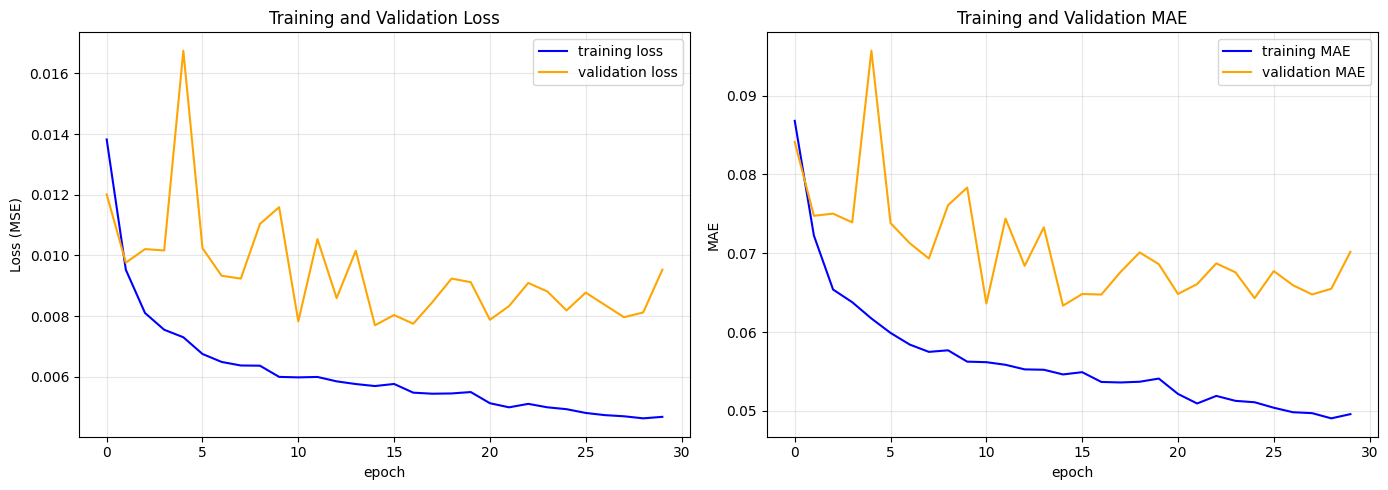

Training history plot saved


In [30]:
# plot training histor  visualising loss curves helps identify overfitting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# loss plot= MSE 
axes[0].plot(history.history['loss'], label='training loss', color='blue')
axes[0].plot(history.history['val_loss'], label='validation loss', color='orange')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#MAE plot
axes[1].plot(history.history['mae'], label='training MAE', color='blue')
axes[1].plot(history.history['val_mae'], label='validation MAE', color='orange')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print('Training history plot saved')

### what i see in my plot

**Left Side: Loss Plot :**

Training loss drops smoothly throughout training. Validation loss also decreases but with jumps up and down. Both lines trend downward which means model is learning.

**Right Side MAE Plot:**

Same pattern. Training MAE drops steadily. Validation MAE is noisier but follows the same downward trend.

**Why Validation Line is Jumpy?**

Validation set is smaller than training set. Smaller dataset means each batch has more impact on the score. some batches contain harder samples than others. This is normal behaviour.

**The meaning of gap between lines:**

training line ends lower than validation line. This small gap shows mild overfitting but acceptable. Model learned patterns that work slightly better on training data than new data.

**Why training keeps dropping but validation flattens:**

After a certain point, training loss keeps going down but validation loss stays flat. Model kept fitting training data better but stopped improving on unseen data. This is exactly what early stopping caught it picked the epoch where validation was best, not where training was best.

**Summary of training historu plot:**

Both lines go down and stay relatively close. No sign of serious overfitting. Model is learning and generalising well.

## 7. Evaluate The Model

Use the same metrics as random forest for fair comparison: RMSE, MAE, R². Evaluate on all three sets to check overfitting.

from scikit-learn documentation, R² is "the proportion of variance in the dependent variable that is predictable from the independent variable(s)."

source: R2_score (no date) scikit. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html (Accessed: 22 December 2025). 

In [31]:
def evaluate_model(model, X, y_true, set_name):
    """
    evaluate model on a dataset.
    
    returns dict with RMSE, MAE, R^2
    """
    # get predictions
    y_pred = model.predict(X, verbose=0).flatten() #random forest training:     y_pred = model.predict(X)

    
    # calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'{set_name}:')
    print(f'  RMSE: {rmse:.6f}')
    print(f'  MAE:  {mae:.6f}')
    print(f'  R^2:   {r2:.6f}')
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'y_pred': y_pred}



In [32]:
#Evaluate all sets
print('Model evaluation')
print('=' * 40)

train_results = evaluate_model(model, X_train, y_train_single, 'training')
print()
val_results = evaluate_model(model, X_val, y_val_single, 'validation')
print()
test_results = evaluate_model(model, X_test, y_test_single, 'test')

Model evaluation
training:
  RMSE: 0.067764
  MAE:  0.048689
  R^2:   0.742720

validation:
  RMSE: 0.087741
  MAE:  0.063351
  R^2:   0.670059

test:
  RMSE: 0.072491
  MAE:  0.051917
  R^2:   0.615448


    Model evaluation
    ========================================
    training:
    RMSE: 0.067764
    MAE:  0.048689
    R^2:   0.742720

    validation:
    RMSE: 0.087741
    MAE:  0.063351
    R^2:   0.670059

    test:
    RMSE: 0.072491
    MAE:  0.051917
    R^2:   0.615448

### overfitting check

Training R² is 0.74, test R² is 0.62. the gap of 0.12 shows some overfitting. Model learned patterns from training data that don't fully transfer to unseen data.

For comparison, RF had a similar gap (training 0.97, test 0.81 = gap of 0.16). both models show some overfitting but CNN's gap is actually smaller.

The overfitting is mild, not severe. Model still generalises reasonably well to new data.


In [33]:
#overfitting gap
overfit_gap = train_results['r2'] - test_results['r2']

print(f'\noverfitting analysis:')
print(f'  training R²:   {train_results["r2"]:.6f}')
print(f'  test R²:       {test_results["r2"]:.6f}')
print(f'  gap:           {overfit_gap:.6f}')


overfitting analysis:
  training R²:   0.742720
  test R²:       0.615448
  gap:           0.127272


    overfitting analysis:
    training R²:   0.742720
    test R²:       0.615448
    gap:           0.127272


## 8. visualisations

Same plots as random forest report for consistency: scatter plots and time series comparison.

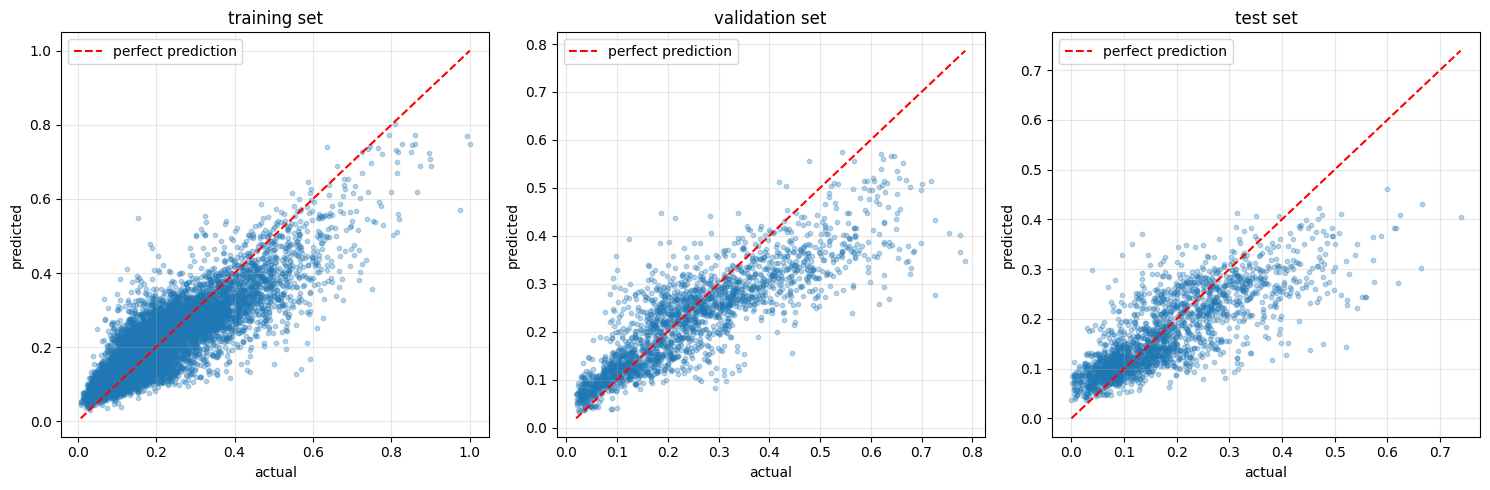

Scatter plots saved


In [35]:
# scatter plots: actual vs predicted
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sets = [
    ('training', y_train_single, train_results['y_pred']),
    ('validation', y_val_single, val_results['y_pred']),
    ('test', y_test_single, test_results['y_pred'])
]

for ax, (name, actual, predicted) in zip(axes, sets):
    ax.scatter(actual, predicted, alpha=0.3, s=10)
    
    # perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='perfect prediction')
    
    ax.set_xlabel('actual')
    ax.set_ylabel('predicted')
    ax.set_title(f'{name} set')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print('Scatter plots saved')

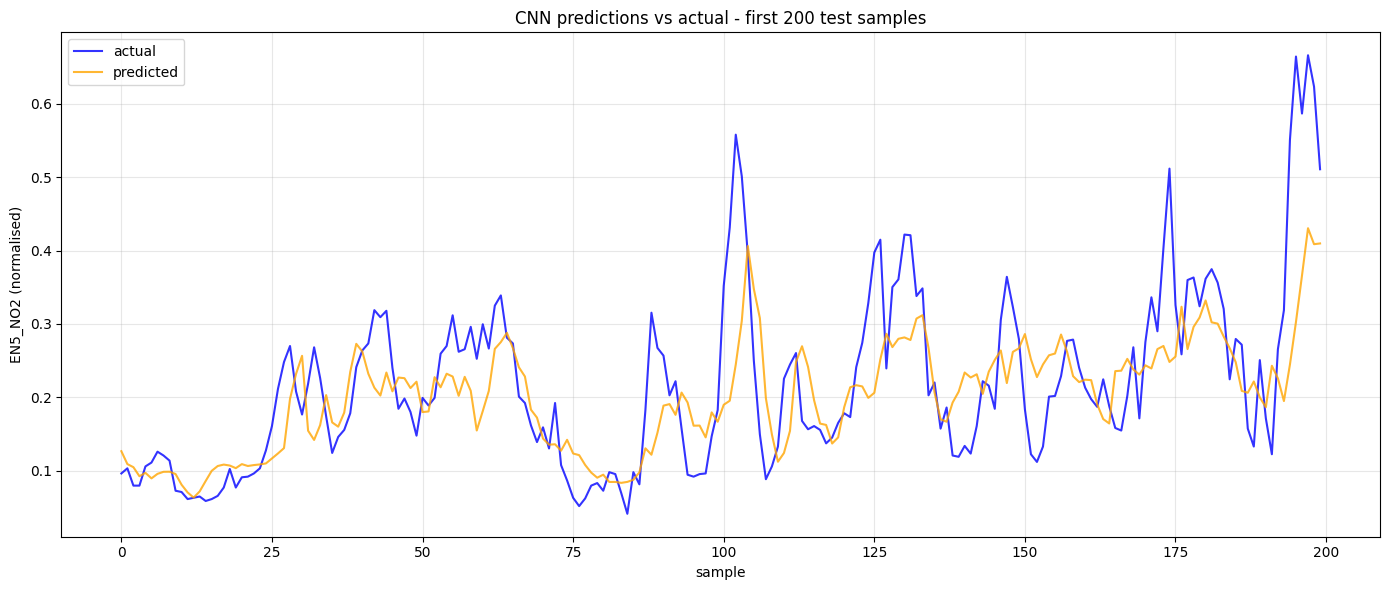

In [36]:
# time series comparison first 200 test samples
n_samples = 200

plt.figure(figsize=(14, 6))
plt.plot(y_test_single[:n_samples], label='actual', color='blue', alpha=0.8)
plt.plot(test_results['y_pred'][:n_samples], label='predicted', color='orange', alpha=0.8)
plt.xlabel('sample')
plt.ylabel(f'{target_name} (normalised)')
plt.title(f'CNN predictions vs actual - first {n_samples} test samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'time_series_comparison_200sample.png', dpi=150, bbox_inches='tight')
plt.show()

### What the time series plot shows

Orange line (predicted) follows blue line (actual) general pattern. When pollution goes up, prediction goes up. When pollution goes down, prediction goes down. Model captures the overall trend.

** Problem: **

At peaks, predicted line doesn't reach as high as actual. Model underpredicts high pollution events. Same problem I found in RF.

**Why this happens?**

most training data is low-to-medium pollution. high spikes are rare. Model learned the common pattern well but doesn't see enough extreme events to learn them properly.

**Irony:**

Good news for london air quality is mostly good so extreme pollution events are rare. Bad news for my model not enough extreme samples to learn from them.

## 9) Residual analysis

Residuals are the difference between actual and predicted values. If the model is good, residuals should scatter randomly around zero with no pattern.

residual = actual - predicted

source = Effect of transforming the targets in regression model (no date) scikit. Available at: https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html (Accessed: 26 December 2025). 

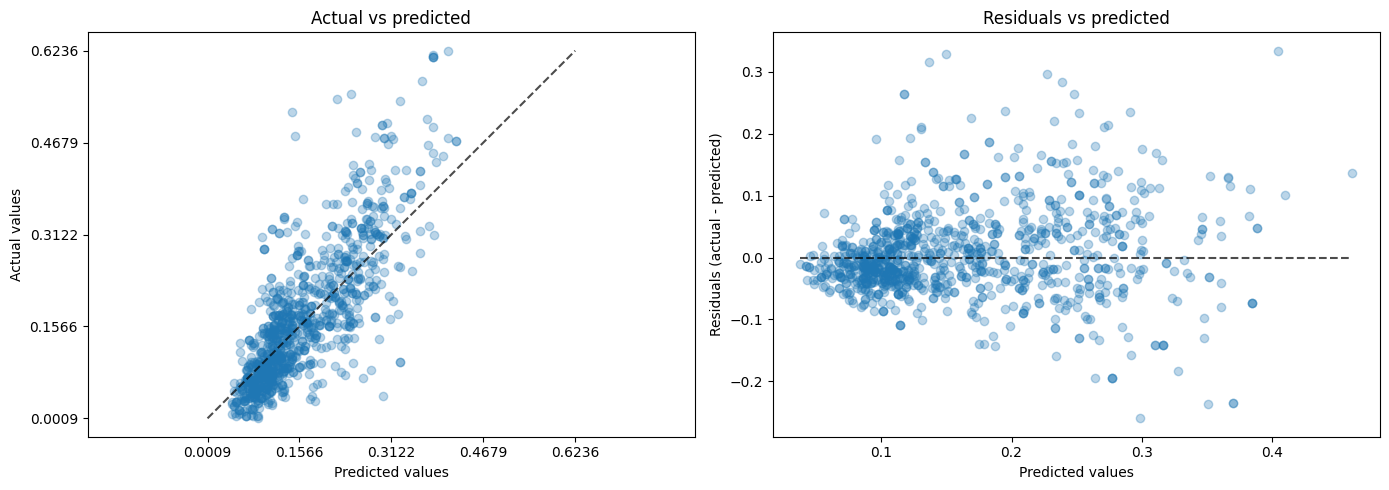

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs predicted plot
PredictionErrorDisplay.from_predictions(
    y_test_single,
    test_results['y_pred'],
    kind="actual_vs_predicted",
    ax=axes[0],
    scatter_kwargs={"alpha": 0.3}
)
axes[0].set_title('Actual vs predicted')

# Residual plot
PredictionErrorDisplay.from_predictions(
    y_test_single,
    test_results['y_pred'],
    kind="residual_vs_predicted",
    ax=axes[1],
    scatter_kwargs={"alpha": 0.3}
)
axes[1].set_title('Residuals vs predicted')

plt.tight_layout()
plt.savefig(output_dir / 'residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### What residual analysis plots says?

**Left plot (actual vs predicted):**

points follow the dashed line at low values but scatter above it at higher values. points above the line mean actual is higher than predicted - model underpredicts high pollution.

**Right plot (residuals vs predicted):**

residuals should scatter randomly around zero. at low predictions, residuals cluster near zero which is good. at higher predictions, residuals spread upward showing systematic underprediction.

**Comment:**

model handles normal pollution well but struggles with high pollution events. the spread increases at higher values - model is confident about low pollution but uncertain about high pollution.

**What could be the next step:**

Results are not poor but tuning might help. will try hyperparameter tuning to see if model can perform better.

## 10) Tuning

I will be use KerasTuner:
 > KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search. Easily configure your search space with a define-by-run syntax, then leverage one of the available search algorithms to find the best hyperparameter values for your models. KerasTuner comes with Bayesian Optimization, Hyperband, and Random Search algorithms built-in, and is also designed to be easy for researchers to extend in order to experiment with new search algorithms.

 Source: Team, K. (no date) Keras Documentation: Kerastuner, Keras. Available at: https://keras.io/keras_tuner/ (Accessed: 26 December 2025). 

 ### Guided codes from KerasTuner:

 ```
 # import statements as usual:
 import keras_tuner
import keras

def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
best_model = tuner.get_best_models()[0]
 ```

### Tuning method

Using RandomSearch tries random combinations of hyperparameters. faster than testing every possible combination. Will run 20 trials, each with early stopping.
 

In [ ]:
def build_model(hp):
    """ Model builder func for KerasTuner hyperparameter tuning."""

    model = keras.Squential()

    #conv1D because time series not flat data
    model.add(tf.keras.layers.Conv1D(
    filters=hp.Choice('filters_1', [32, 64, 128]), #param of conv1D layer, 32 default and the others powers of 32 
        kernel_size=hp.Choice('kernel_1', [2, 5, 12]), #2 hours captures short changes, 5 medium used on report (2021a) ‘Air quality prediction using CNN+LSTM-based hybrid.. and 12 longg term rush hour parttern
        activation='relu',
        padding='causal',
        input_shape=(timesteps, n_features) #input shape of data
    ))
    model.add(tf.keras.layers.Dropout(hp.Choice('dropout_1', [0.1, 0.2, 0.3]))) # dropout to prevent overfitting